In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
checkpoint = "checkpoint.pt"

batch_size = 1

test_dataset = datasets.MNIST(root='./mnist_data/',
                             train=False,
                             transform=transforms.ToTensor(),
                              download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8702983.55it/s]                            


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 128737.10it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


1654784it [00:00, 2140782.44it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


8192it [00:00, 49016.09it/s]            


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(num_features=64)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=5, stride = 1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels = 64, kernel_size=5, stride = 2)
        self.dropout1 = nn.Dropout(0.25)
        self.FC1 = nn.Linear(64 *12 * 12, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.FC2 = nn.Linear(128, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(in_size, -1)
        x = self.dropout1(x)
        x = self.relu(self.FC1(x))
        x = self.dropout2(x)
        x = self.FC2(x)
        # x = F.softmax(x)

        return x

In [5]:
model = Net()
model.load_state_dict(torch.load(checkpoint))
model.eval()

Net(
  (relu): ReLU()
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (dropout1): Dropout(p=0.25, inplace=False)
  (FC1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (FC2): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test( model, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print( target)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [8]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Epsilon: 0	Test Accuracy = 9758 / 10000 = 0.9758
Epsilon: 0.05	Test Accuracy = 9423 / 10000 = 0.9423
Epsilon: 0.1	Test Accuracy = 8424 / 10000 = 0.8424
Epsilon: 0.15	Test Accuracy = 5762 / 10000 = 0.5762
Epsilon: 0.2	Test Accuracy = 3001 / 10000 = 0.3001
Epsilon: 0.25	Test Accuracy = 1379 / 10000 = 0.1379
Epsilon: 0.3	Test Accuracy = 530 / 10000 = 0.053


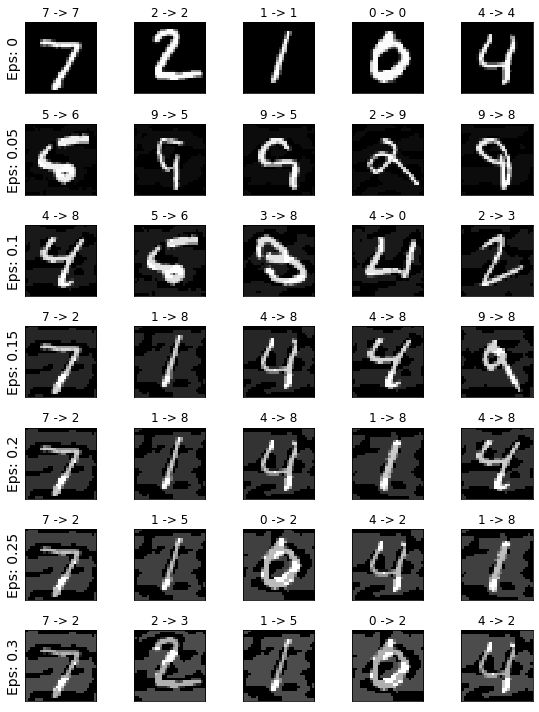

In [9]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()